# Preliminary setup and data exploration

In [1]:
import os
os.chdir('..')

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
random.seed(100)
np.random.seed(100)

In [3]:
from src.agents import *

In [4]:
#data = pd.read_csv('data/movielens_10_arms.csv') #easy
#data = pd.read_csv('data/movielens_202_arms.csv') #lots of arms

#data = pd.read_csv('data/yahoo_reduced_arms.csv') #harder
data = pd.read_csv('data/10000dataset.csv')
# Reshuffle data
data = data.sample(frac=1, random_state=100)
data = data.reset_index()

In [5]:
features_columns = []

In [6]:
n_features = 0
for column in data.columns:
    try:
        _ = int(column)
        features_columns.append(column)
    except:
        pass
n_features = len(features_columns)

In [7]:
# Number of arms
n_arms = data['selected_arm'].max() + 1
n_arms = int(n_arms)
n_arms

10

In [8]:
data

,index,0,1,2,3,4,5,6,7,8,...,92,93,94,95,96,97,98,99,selected_arm,reward
0,8018,2,0,0,21,1,0,0,0,0,...,0,3,0,0,15,28,7,0,2,0
1,9225,39,0,0,36,0,0,0,0,0,...,0,0,0,0,0,19,0,1,5,0
2,3854,14,2,0,42,0,0,18,0,0,...,7,2,0,4,0,0,0,9,0,0
3,2029,11,3,0,30,0,0,16,0,0,...,6,2,0,3,1,0,0,7,7,0
4,3539,2,8,0,0,0,11,0,0,33,...,0,0,0,34,0,0,0,0,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,350,43,0,0,34,1,0,0,0,0,...,0,0,0,0,0,6,0,1,5,0
9996,79,1,4,30,0,0,0,0,0,0,...,5,0,5,3,0,0,0,11,7,0
9997,8039,42,1,2,42,1,0,0,0,1,...,0,0,0,0,0,14,0,0,2,0
9998,6936,6,0,0,0,0,0,0,0,0,...,0,0,15,0,22,1,0,0,1,0


In [9]:
data.sample(n=5, random_state=100)

,index,0,1,2,3,4,5,6,7,8,...,92,93,94,95,96,97,98,99,selected_arm,reward
8018,9815,43,0,1,30,1,0,0,0,0,...,0,0,0,0,0,19,0,1,7,0
9225,2780,30,0,1,41,1,0,0,0,0,...,0,0,0,0,0,11,0,1,3,0
3854,7167,27,0,0,27,0,0,0,0,0,...,0,0,0,0,0,15,0,2,8,0
2029,4639,6,7,0,39,0,0,22,0,0,...,6,1,0,3,1,0,0,5,0,0
3539,9137,44,0,4,34,0,0,0,0,0,...,0,0,0,0,0,20,0,1,5,0


In [10]:
data.shape

(10000, 103)

There are 22 different arms. They seem to have been chosen uniformly randomly:

In [11]:
data['selected_arm'].describe()

count    10000.000000
mean         4.489600
std          2.868609
min          0.000000
25%          2.000000
50%          4.000000
75%          7.000000
max          9.000000
Name: selected_arm, dtype: float64

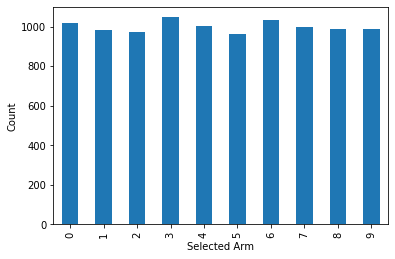

In [12]:
data['selected_arm'].value_counts().sort_index().plot(kind='bar')
plt.xlabel('Selected Arm')
plt.ylabel('Count')
plt.show()

The reward is a Bernoulli distribution:

In [13]:
data['reward'].describe()

count    10000.000000
mean         0.103900
std          0.305146
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          1.000000
Name: reward, dtype: float64

The reward expectancy depends on the arm chosen:

Text(0.5, 0, 'Selected Arm')

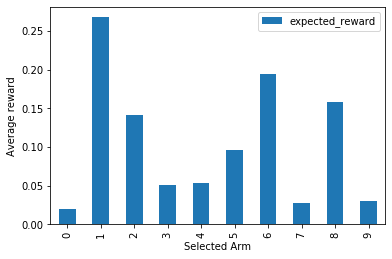

In [14]:
expected_reward = data.groupby('selected_arm').agg({'reward':'mean'}).rename({'reward':'expected_reward'},axis=1)
expected_reward.plot(kind='bar')
plt.ylabel('Average reward')
plt.xlabel('Selected Arm')

In [15]:
data.groupby('selected_arm').agg({'reward':'mean'}).sort_values('reward', ascending=False)

,reward
selected_arm,
1,0.267821
6,0.194203
8,0.158907
2,0.141684
5,0.096573
4,0.053731
3,0.051576
9,0.030395
7,0.028028


All 136 features are bernoulli

# Using PCA to lower the number of dimensions

In [16]:
n_pca = 4

from sklearn import decomposition

pca = decomposition.PCA(n_components=4)
X = pca.fit_transform(data[features_columns])

data = pd.concat([pd.DataFrame(X), data[['selected_arm', 'reward']]], axis=1)
n_features = n_pca
features_columns = range(n_pca)

In [17]:
data

,0,1,2,3,selected_arm,reward
0,0.862381,15.824105,-4.728823,15.846460,2,0
1,-36.641955,-42.565999,-0.982176,8.473514,5,0
2,-28.908081,47.025209,78.836566,-21.715712,0,0
3,-24.208872,48.231416,74.760137,-19.219603,7,0
4,10.075641,13.394291,-2.872530,27.707311,3,0
...,...,...,...,...,...,...
9995,-36.450589,-42.686482,-2.199960,4.059316,5,0
9996,65.823293,-22.576758,3.729309,-17.962800,7,0
9997,-36.484401,-38.862534,-2.665262,5.289559,2,0
9998,26.334520,44.600940,-18.668215,65.341994,1,0


In [18]:
#plt.scatter(data[0], data[1])

# Defining a base Agent other will be based upon

These are the basic properties of a multi-armed bandit.

In [19]:
Agent??

Init signature: Agent(n_arms)
Source:        
class Agent():
    """Base properties of all multi-armed bandits."""
    def __init__(self, n_arms):
        """
        n_arms: int
            Number of arms
        """
        self.n_arms = n_arms
        self.tries = np.zeros(n_arms)
        self.successes = np.zeros(n_arms)
        
    @property
    def _total_tries(self): 
        return self.tries.sum()
    
    def add_observation(self, arm, reward):
        """An observation consists of a pair `(arm, reward)`.
        arm: int
            Chosen arm of the observation
        reward: float
            Reward of the observation
        """
        self.tries[arm] += 1
        self.successes[arm] += reward
    
    def select_arm(self):
        """Placeholder way of selecting an arm."""
        arm = self._total_tries % self.n_arms
        return arm
File:           ~/Repos/bandits/src/agents.py
Type:           type
Subclasses:     GreedyExploreFirst, EpsilonGreedy, UCB1, BayesUCB,

# Contextual Agent

In [20]:
class ContextualAgent(Agent):
    """Base properties of all contextual multi-armed bandits."""
    def __init__(self, n_arms, n_features):
        super().__init__(n_arms)
        self.n_features = n_features
    
    def add_observation(self, arm, reward, X):
        super().add_observation(arm, reward)

# Implementing LinUCB

In [21]:
class LinUCB(ContextualAgent):
    """LinUCB with disjoint linear models for each arm."""
    def __init__(self, n_arms, n_features, alpha=1):
        super().__init__(n_arms, n_features)
        self.alpha = alpha
        self._A = np.array([np.identity(n_features) for arm in range(n_arms)]) # One n_features x n_feature matrix per arm
        self._b = np.array([np.zeros([n_features, 1]) for arm in range(n_arms)]) # One n_features x 1 vector per arm
    
    def add_observation(self, arm, reward, X):
        super().add_observation(arm, reward, X)
        self._A[arm] += np.dot(X, X.T)
        self._b[arm] += reward * X
        
    @property
    def _Ainv_theta(self):
        A_inv = [np.linalg.inv(self._A[arm]) for arm in range(n_arms)]
        theta = [np.dot(A_inv[arm], self._b[arm]) for arm in range(n_arms)]
        return A_inv, theta

    def _get_UCB(self, X):
        A_inv, theta = self._Ainv_theta
        UCB = [np.dot(theta[arm].T, X) +  self.alpha * np.sqrt(np.dot(X.T, np.dot(A_inv[arm], X))) for arm in range(n_arms)]
        UCB = np.array(UCB)
        return UCB
    
    def select_arm(self, X):
        UCB = self._get_UCB(X)
        arm = argmax(UCB)
        return arm

# Using 

In [22]:
agent = LinUCB(n_arms=n_arms, n_features=n_features, alpha=1)

In [23]:
%%time
Rewards = []
Selected_Arms = []
Indexes = []
for index in range(len(data)):
    X = data.loc[index, features_columns]
    X = X.values.reshape([-1,1])
    selected_arm = agent.select_arm(X)
    if selected_arm == data.loc[index, 'selected_arm']:
        reward = data.loc[index, 'reward']
        agent.add_observation(selected_arm, reward, X)
        Rewards.append(reward)
        Selected_Arms.append(selected_arm)
        Indexes.append(index)
        
Cumulative_Reward = np.array(Rewards).cumsum()

CPU times: user 35.1 s, sys: 17.8 s, total: 52.9 s
Wall time: 13.2 s


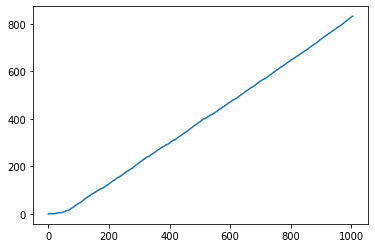

In [24]:
plt.plot(Cumulative_Reward)

In [25]:
pd.Series(Selected_Arms).value_counts()

1    258
6    198
8    156
5    151
2    142
3     47
9     36
7      6
0      6
4      5
dtype: int64

In [26]:
Cumulative_Reward[-1]

832

Plotting results for different values of alpha

CPU times: user 7min 30s, sys: 3min 53s, total: 11min 23s
Wall time: 2min 50s


Text(0.5, 1.0, 'Cumulative Reward for different values of alpha')

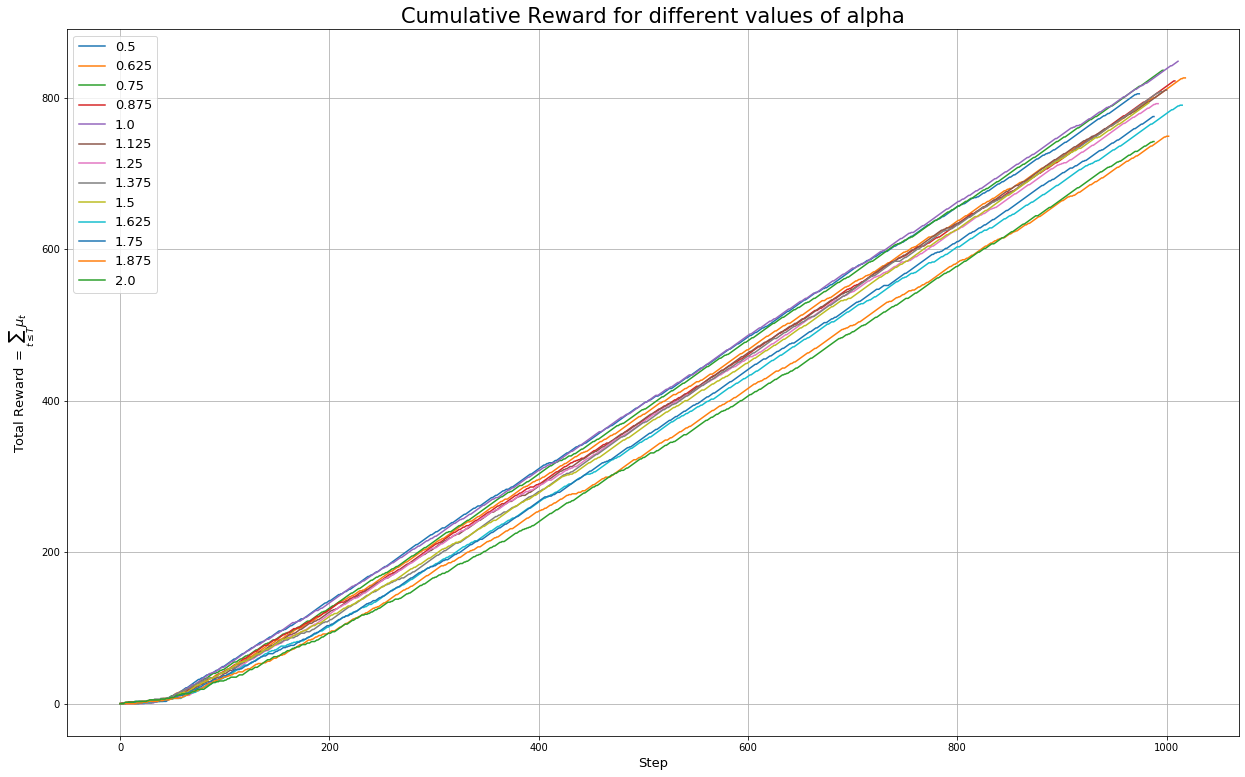

In [27]:
%%time
plt.figure(figsize=(21,13))

Reward_Per_Alpha = []
for alpha in np.linspace(0.5, 2, 13):
    agent = LinUCB(n_arms=n_arms, n_features=n_features, alpha=alpha)
    Rewards = []
    for index in range(len(data)):
        X = data.loc[index, features_columns]
        X = X.values.reshape([-1,1])
        selected_arm = agent.select_arm(X)
        if selected_arm == data.loc[index, 'selected_arm']:
            reward = data.loc[index, 'reward']
            agent.add_observation(selected_arm, reward, X)
            Rewards.append(reward)

    Cumulative_Reward = np.array(Rewards).cumsum()
    plt.plot(Cumulative_Reward, label=f'{alpha}')
    Reward_Per_Alpha.append(Cumulative_Reward[-1])

plt.legend(fontsize=13)
plt.xlabel('Step', fontsize=13)
plt.ylabel('Total Reward $= \sum_{t \leq T} \mu_t$', fontsize=13)
plt.grid()
plt.title('Cumulative Reward for different values of alpha',fontsize=21)

Text(0.5, 1.0, 'Cumulative Reward for different values of alpha')

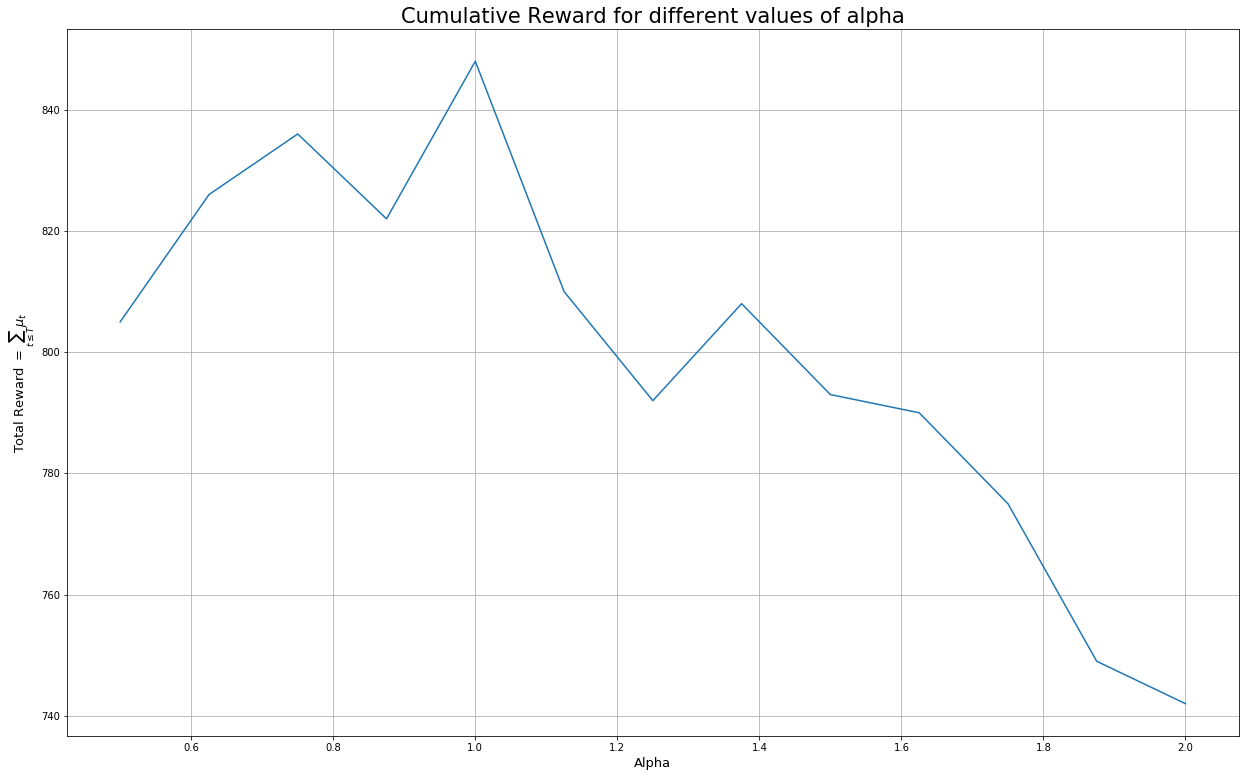

In [28]:
plt.figure(figsize=(21,13))
plt.plot(np.linspace(0.5, 2, 13), Reward_Per_Alpha)
plt.xlabel('Alpha', fontsize=13)
plt.ylabel('Total Reward $= \sum_{t \leq T} \mu_t$', fontsize=13)
plt.grid()
plt.title('Cumulative Reward for different values of alpha',fontsize=21)

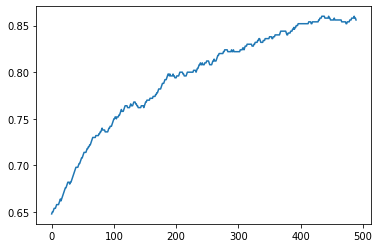

In [29]:
k = 500
last_k_ctr = np.convolve(np.array(Rewards), np.ones(k, dtype=int),'valid') / k
plt.plot(last_k_ctr)